<a href="https://colab.research.google.com/github/StefanWoBa/NLP-Kaggle-Competition/blob/main/RealorNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not - Disaster Recognition of Tweets

Inserting Picture !

## 01 Understanding the Problem:


---


### Background Information:
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
But, it’s not always clear whether a person’s words are actually announcing a disaster.

### Task:
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.


Kaggle Competition: https://www.kaggle.com/c/nlp-getting-started/overview

## 02 Data Mining



---



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
! git clone https://github.com/StefanWoBa/NLP-Kaggle-Competition.git
tweets_train = pd.read_csv('NLP-Kaggle-Competition/train.csv')
tweets_test = pd.read_csv('NLP-Kaggle-Competition/test.csv')

fatal: destination path 'NLP-Kaggle-Competition' already exists and is not an empty directory.


### Check for missing values

In [ ]:
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


location    2533
keyword       61
target         0
text           0
id             0
dtype: int64


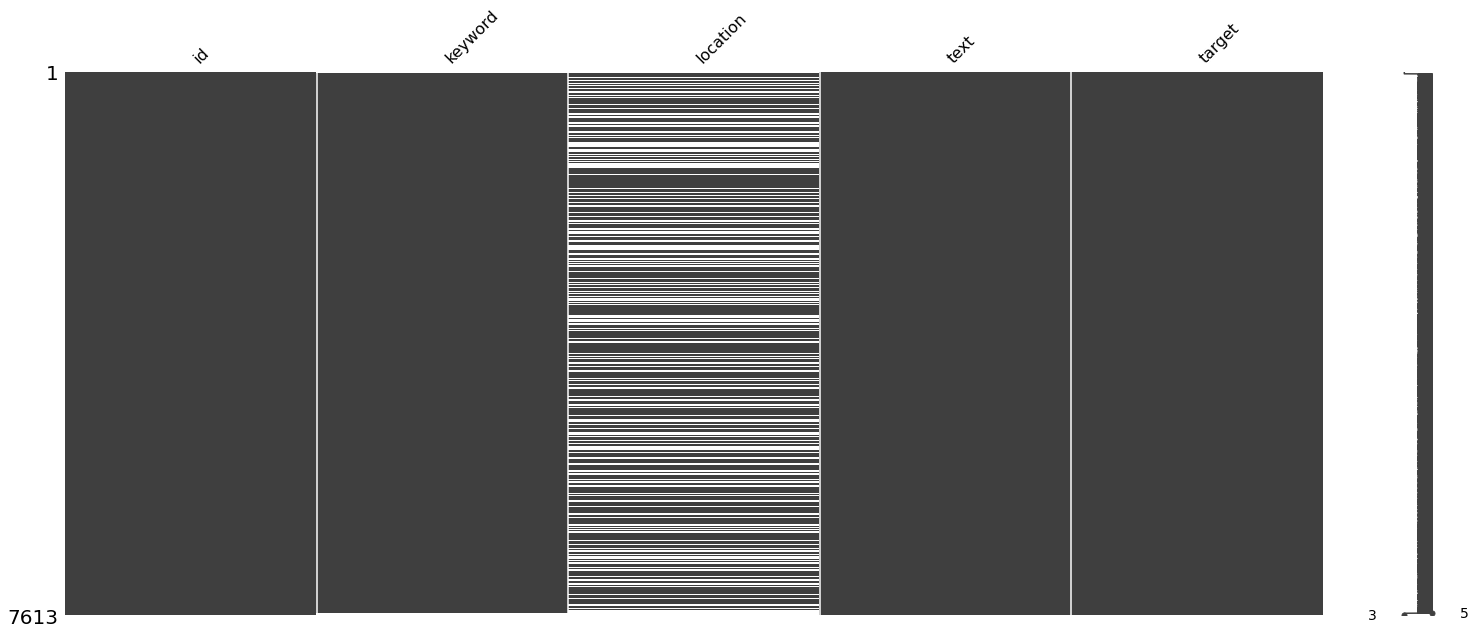

In [ ]:
import missingno
#create graph
missingno.matrix(tweets_train)
#create additional list
missing_data = tweets_train.isnull().sum().sort_values(ascending=False)
print(missing_data)

**Observation:** Missing values seem to be particular pronounced in the location column. There are also empty entries regarding keywords. The focus of this competition lies solely on the text column (and target of course), therefore the NAs are not a problem at all.

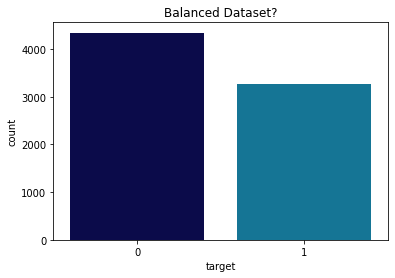

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Balanced?
chart= sns.countplot(x=tweets_train.target, palette='ocean')
plt.title('Balanced Dataset?');

Another important fact before starting the real fun is to check weather or not the target distribution is balanced. From the countplot above, we can see that the training dataset contains more 0s than 1s, but not by a big margin. Therefore, we do not have to apply explicit measures for inbalanced datasets. Nevertheless, we have to keep it in mind in the following chapters. 

### Quick Look at examples:

In [ ]:
# Example of tweet with no real disaster:
tweets_train[tweets_train['target']==0]['text'].values[:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

In [ ]:
# Example of tweet refering to real disaster:
tweets_train[tweets_train['target']==1]['text'].values[:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

### Getting a feeling of the tweets:

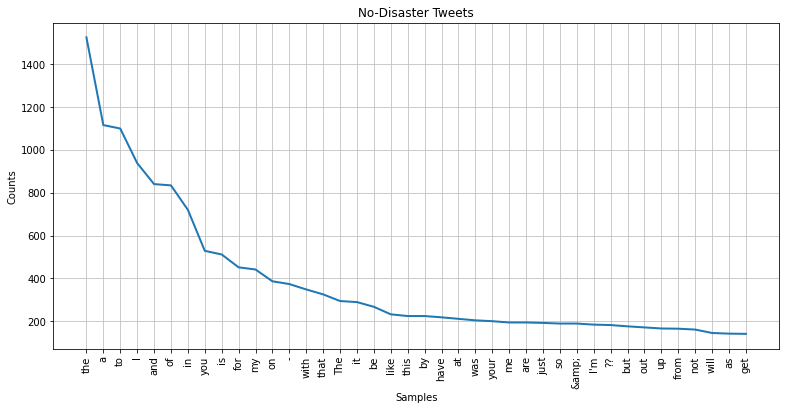

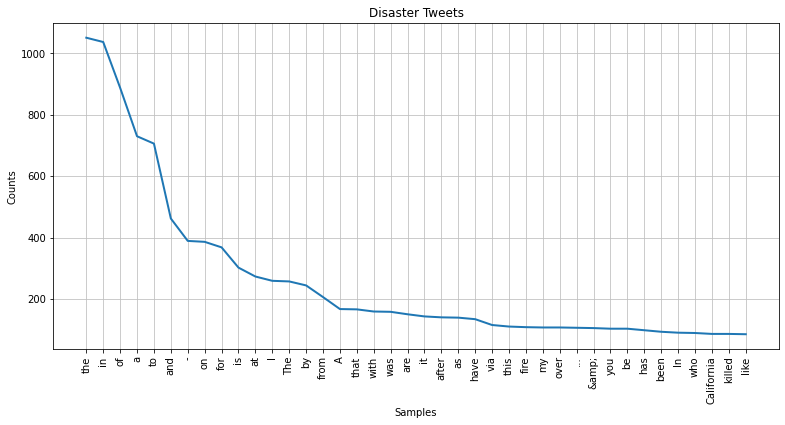

In [ ]:
import nltk
from nltk.probability import FreqDist

### Getting a better understanding of the content of the tweets:
corpus_nodis = ' '.join(tweets_train[tweets_train['target']==0]['text'].values).split()
corpus_dis = ' '.join(tweets_train[tweets_train['target']==1]['text'].values).split()

### Creating a frequency distribution, seperatly for Disaster and No-Disaster Tweets
fdist_nodis = FreqDist(corpus_nodis)
fdist_dis = FreqDist(corpus_dis)

### Plot the frequency distribution of the most common words
plt.figure(figsize=(13,6))
fdist_nodis.plot(40, title='No-Disaster Tweets');
plt.figure(figsize=(13,6))
fdist_dis.plot(40, title='Disaster Tweets');

**Observation:** 
* In both, Disaster and non-Disaster tweets, is a lot of noise, meaning stopwords (the **and** The, a, etc.), html code (&amp) do have high frequencies. This is of course problematic and we have to do a lot of cleaning before we can train our models
* Only the word fire is quite informative within the Disaster Tweets

## 03 Data Cleaning:
---

**Cleaning Text in tweets (in general):**
- stop words
- html code / urls
- hashtags
- lowercase
- punctuation

In [ ]:
#Prepare the Dataset
cols_to_drop = ['id', 'keyword', 'location']
tweets_train = tweets_train.drop(cols_to_drop, axis=1)
tweets_train.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# importing relevant packages and download the stopwoard corpus from nltk
import re
import nltk
nltk.download('stopwords')
# Creating a function which will do all of the cleaning in one step
def clean_tweets(df, text, text_cleaned):
    # lowercase each and every word
    df[text_cleaned] = df[text].str.lower()
    # remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    df[text_cleaned] = df[text_cleaned].apply(lambda elem: ' '.join([word for word in elem.split() if word not in (stopwords)]))
    # deleting urls
    df[text_cleaned] = df[text_cleaned].apply(lambda elem: re.sub(r'http\S+', '', elem))
    # deleting html tags
    df[text_cleaned] = df[text_cleaned].apply(lambda elem: re.sub(r'&\S+', '', elem))
    df[text_cleaned] = df[text_cleaned].apply(lambda elem: re.sub(r'û_'+'*', '', elem))
    # deleting punctions: remove everything that is not a word or a whitespace
    df[text_cleaned] = df[text_cleaned].apply(lambda elem: re.sub('[^\w\s]', '' ,elem)) 
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
### apply function on both, the training and the test dataset
clean_tweets(tweets_train, 'text', 'text_cleaned')
clean_tweets(tweets_test, 'text', 'text_cleaned')
tweets_train.head(5)

,text,target,text_cleaned
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


### Check the cleaning with WordClouds

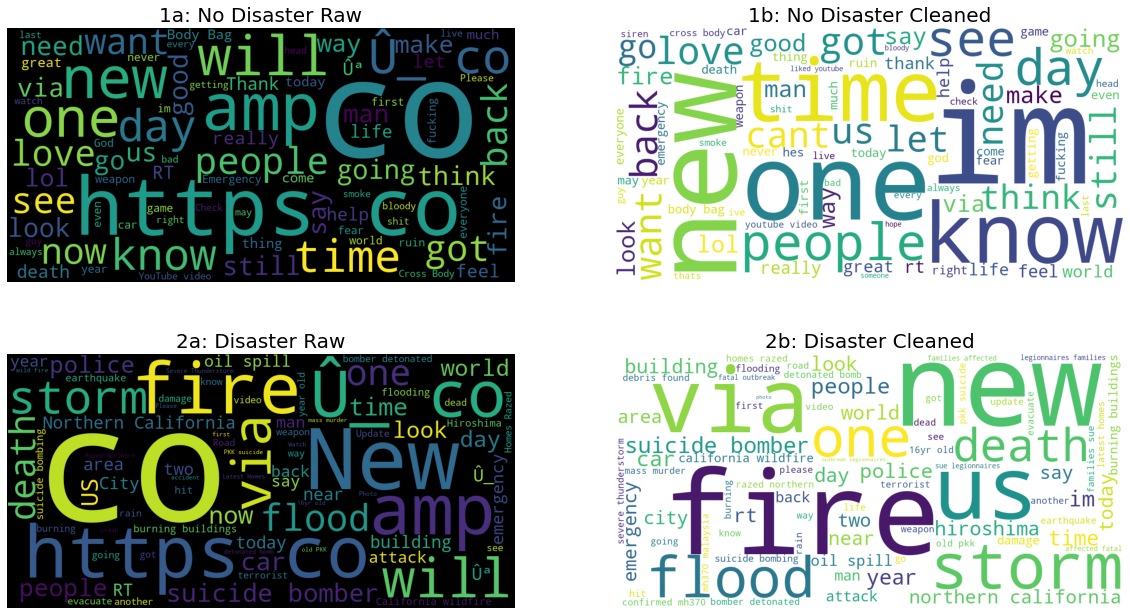

In [ ]:
from wordcloud import WordCloud
#### REIHENFOLGE ÄNDERN ####
# Creating text corpus from the Dataframe
cl_corpus_nodis = ' '.join(tweets_train[tweets_train['target']==0]['text_cleaned'].values) #1
corpus_nodis = ' '.join(tweets_train[tweets_train['target']==0]['text'].values) #2
cl_corpus_dis = ' '.join(tweets_train[tweets_train['target']==1]['text_cleaned'].values) #3
corpus_dis = ' '.join(tweets_train[tweets_train['target']==1]['text'].values) #4

# Creating wordclouds
wordcloud_1 = WordCloud(width=1000, height= 500, background_color='white', max_words=80).generate(cl_corpus_nodis)
wordcloud_2 = WordCloud(width=1000, height= 500, max_words=80).generate(corpus_nodis)
wordcloud_3 = WordCloud(width=1000, height= 500, background_color='white', max_words=80).generate(cl_corpus_dis)
wordcloud_4 = WordCloud(width=1000, height= 500, max_words=80).generate(corpus_dis)


### Configuration of the plot:
rows = 2
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(20,11))

ax[0,0].imshow(wordcloud_2)
ax[0,0].axis('off')
ax[0,0].set_title('1a: No Disaster Raw', fontsize=20)

ax[0,1].imshow(wordcloud_1)
ax[0,1].axis('off')
ax[0,1].set_title('1b: No Disaster Cleaned', fontsize=20)

ax[1,0].imshow(wordcloud_4)
ax[1,0].axis('off')
ax[1,0].set_title('2a: Disaster Raw', fontsize=20)

ax[1,1].imshow(wordcloud_3)
ax[1,1].axis('off')
ax[1,1].set_title('2b: Disaster Cleaned', fontsize=20)

plt.show()

Observation: The cleaning seems to be succesfull, all of the special characters and urls are gone. The plots on the right show a clear pattern in terms of Disaster or No-Disaster words, which was the overall goal of the cleaning (except of the word new)

## 04 Feature Engineering aka Tokenization/ Vectorization:

In this step we want to transform the human-readable form of the words into a pattern a machine can understand. We will use the so-called Bag-of-Words approach (aka one-hot-encoding) by tokenize each word.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
## Tokenize the whole dataset:
simple_vectorizer = CountVectorizer(min_df=5) #the word has to be in at least 5 tweets otherwise it is leaved out, done to further reduce noise
vect = simple_vectorizer.fit(tweets_train['text_cleaned'])
#Vectorize
X_train = vect.transform(tweets_train['text_cleaned'])
#test only use transform (not fit) to ensure that train and test are using the same set of vectors (i.e.tokens)
X_test = vect.transform(tweets_test['text'])
print('The training data has the shape of {}'.format(X_train.shape))
print('The test data has the shape of {}'.format(X_test.shape))

The training data has the shape of (7613, 2651)
The test data has the shape of (3263, 2651)


### Have a closer Look:

In [ ]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20])) 
print("Features 20010 to 20030:\n{}".format(feature_names[2630:])) 
print("Every 2000th feature:\n{}".format(feature_names[::100]))

Number of features: 2651
First 20 features:
['05', '06', '10', '100', '1000', '101', '10th', '11', '11yearold', '12', '12000', '13', '14', '15', '16', '16yr', '17', '18', '19', '1945']
Features 20010 to 20030:
['years', 'yes', 'yesterday', 'yet', 'yo', 'york', 'you', 'young', 'youngheroesid', 'your', 'youth', 'youtube', 'youªve', 'yr', 'yrs', 'yyc', 'z10', 'zionist', 'zombie', 'zone', 'ïwhen']
Every 2000th feature:
['05', 'aftershock', 'ask', 'bleeding', 'campaign', 'collapsed', 'dangerous', 'drawn', 'everything', 'fix', 'goes', 'hiring', 'interview', 'latest', 'madhya', 'mod', 'nuclear', 'percent', 'promises', 'republicans', 'scheme', 'sit', 'strange', 'the', 'tried', 'vs', 'worried']


**Observations:** 
* Overall, there are 2651 features (= unique words)
* The output above shows that there is still some noise, for example we do have a token called years as well as its abbreviation yr. But for now, we will leave it at that. 

## 05 Predictive Modeling
---

### 05.1 Basic Models

In this chapter, we want will write a function which compares several different ML Algorithms in order to find the best one for the problem at hand.
First, we try out some basic Models and aftherwards go on with deep learning models aka Neural Networks. 

Metric: f1 score: ADD EXPLANATION

#### Model Comparison with k-fold Cross Validaton
We will use k-fold Cross Validation in order to create a robust comparison between the models. CV is the porocess of seperate the dataset in k-folds, where k is the number of proportions we need to realize the data.

From literature best ML-Models in respect to Text classifiaction are the following:
   * Naive Bayes Models (Bernoulli, Gaussian, etc.)
   * Support Vector Machines (SVM)
   * Several Ensamble Methods like XGBoost and Adaboost
   * and of course deep learning (neural networks) which will be discussed in the next chapter

In [ ]:
# Importing Models:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn import tree
# Importing relevant packages
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

LR: 0.74879 (0.01201)
MNB: 0.75105 (0.01794)
BNB: 0.75042 (0.01530)
SVM: 0.75132 (0.00915)
CART: 0.69150 (0.00644)
RFC: 0.72787 (0.00675)
GBC: 0.59933 (0.01703)
ABC: 0.65341 (0.01278)
XGB: 0.56396 (0.01888)


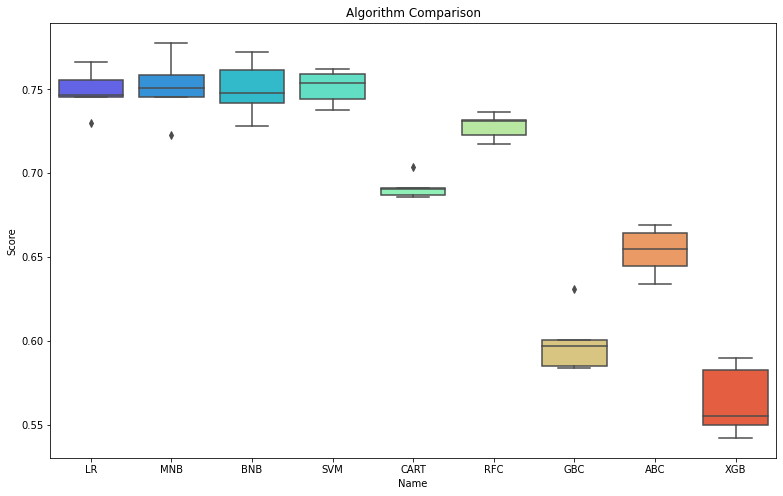

In [ ]:
# create a graph which compares all of the relevant algorithms:
models = []
# Baseline Model
models.append(('LR', LogisticRegression()))
# Naive Bayes Models:
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))
#SVM:
models.append(('SVM', svm.SVC()))
# Ensemble Methods:
models.append(('CART', tree.DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = model_selection.cross_val_score(model, X_train, tweets_train['target'], cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.5f (%.5f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Create a dataframe for a graph:
results_df = pd.DataFrame(list(zip(results, names)), columns=['Score', 'Name']).explode('Score')
# boxplot algorithm comparison
fig, ax = plt.subplots(figsize=(13,8))
ax.set_title('Algorithm Comparison')
sns.boxplot(x='Name', y='Score', data=results_df, ax=ax, palette='rainbow');

**Observation** 
* The simpler Models like  Naive Bayes Models seem to do a better job in terms of the f1 score (as wells as Support Vector Machines)
* Ensemble Methods like XGBoost and AdaBoost perform not as good, therefore will not be considered in the next chapter (Hypterparamter tuning)

Next step: Focus on best performing algortihms solely which are for the problem at hand:
* MNB
* BNB
* SVM   

#### Hyper Paramter Tuning

A common way to further improve our algorithms is to perform Hyperparameter Tuning. We will do this with the help of sklearns GridSearch

In [ ]:
# Create a function which produces a nice and understanding output:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
from sklearn.model_selection import GridSearchCV 
### Tuning Support Vector Machine Algorithm:
param_grid = {'C': [100, 10, 1.0, 0.1, 0.001],  
              'gamma': [1.5, 1.3, 1, 0.1, 0.5, 'scale'],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
              } 

grid_search = GridSearchCV(svm.SVC(), param_grid, scoring='f1', verbose=1, cv=kfold)


grid_search.fit(X_train, tweets_train['target'])
report(grid_search.cv_results_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 46.2min finished


Model with rank: 1
Mean validation score: 0.7513 (std: 0.0091)
Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.7507 (std: 0.0083)
Parameters: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.7451 (std: 0.0112)
Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}



In [ ]:
### Tuning Multinomial NB Algorithm:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 6, 8,10.0]
             }

grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='f1', verbose=1, cv=kfold)
grid_search.fit(X_train, tweets_train['target'])
report(grid_search.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Model with rank: 1
Mean validation score: 0.7521 (std: 0.0163)
Parameters: {'alpha': 0.5}

Model with rank: 2
Mean validation score: 0.7510 (std: 0.0179)
Parameters: {'alpha': 1.0}

Model with rank: 3
Mean validation score: 0.7501 (std: 0.0113)
Parameters: {'alpha': 0.1}



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


In [ ]:
### Tuning Bernoulli NB Algorithm:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 6, 8,10.0]
             }

grid_search = GridSearchCV(BernoulliNB(), param_grid, scoring='f1', verbose=1, cv=kfold)
grid_search.fit(X_train, tweets_train['target'])
report(grid_search.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.7537 (std: 0.0126)
Parameters: {'alpha': 0.5}

Model with rank: 2
Mean validation score: 0.7526 (std: 0.0103)
Parameters: {'alpha': 0.1}

Model with rank: 3
Mean validation score: 0.7504 (std: 0.0153)
Parameters: {'alpha': 1.0}



[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


**Conlcusion:** After comparing the most popular ML Algorithm (with respect to text classification) and tuning the hyperparameter for the most promising models, Bernoulli NB does the best job in classifying the tweets into disaster and not disaster tweets (in terms of the F-1 Score).  

### 05.2 Neural Networks - BERT



In this chapter we will use Neural Networks in order to classify the text more accurate than the basic models. 
We will use a pretrained model called BERT wich is considered as state-of-the art within the NLP Community.
To learn more about BERT and its underlying structure have a look at this guide: http://jalammar.github.io/illustrated-bert/

### Setup

We will use tensorflow and the transformers library in order to get BERT working. Link to the documentation: https://huggingface.co/transformers/

In [ ]:
# import tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
pip install transformers

### Tokenization

we have to apply special tokenization for the BERT model.

In [ ]:
from transformers import BertTokenizer

In [ ]:
### Prepare dataset:
tweets = tweets_train['text_cleaned']
labels = tweets_train['target']
len(tweets), len(labels)

(7613, 7613)

In [ ]:
# import Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def tweet_encoder(data):
  max_length=52 # longest tweet in the training datset
  input_ids_list = []
  attention_masks_list = []
  token_type_ids_list = []

  for sentence in data:
    bert_input = tokenizer.encode_plus(sentence,
                                      add_special_tokens=True,
                                      max_length=max_length,
                                      padding='max_length',
                                      return_attention_mask=True
  )

    input_ids_list.append(bert_input['input_ids'])
    attention_masks_list.append(bert_input['attention_mask'])
    token_type_ids_list.append(bert_input['token_type_ids'])

  input_ids = np.asarray(input_ids_list)
  attention_masks = np.array(attention_masks_list)
  token_type_ids = np.array(token_type_ids_list)

  return input_ids, attention_masks, token_type_ids

In [ ]:
input_ids, attention_masks, token_type_ids = tweet_encoder(tweets)
labels = np.array(labels)
print('Check the encoding {}, {}, {}'. format(len(input_ids), len(attention_masks), len(token_type_ids)))

Check the encoding 7613, 7613, 7613


In the chapter above, we used cross validation in order to get robust results, this is not possible for Neural Networks, therefore we have to split the data in train and test before we configure our model in more detail.

In [ ]:
### Split the dataset in train and test:
from sklearn.model_selection import train_test_split
ids_train,ids_test,label_train,label_test, mask_train, mask_test, tids_train, tids_test = train_test_split(input_ids, labels, attention_masks, token_type_ids, test_size=0.15, shuffle=True, stratify=labels)
print('Shape of training data', ids_train.shape)
print('Shape of testing data', ids_test.shape)

Shape of training data (6471, 52)
Shape of testing data (1142, 52)


So, we get over 6000 tweets to train our model and around 1.100 tweets to test it afterwards

### Model Creation and fine-tuning

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

number_of_epochs = 6

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#classifier Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

#adding callbacks for early stopping and save best model during training process:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, verbose=1)
save_best = tf.keras.callbacks.ModelCheckpoint('best_bert.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=1)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We load the pretrained BERT model and did some configurations such as optimizer and loss function with the recommended settings.
We also included early stopping in the model because the BERT model overfits quite soon (especially when fine-tuned on smaller datasets)

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bert_history = model.fit([ids_train, mask_train, tids_train], label_train, batch_size=16, epochs=6, validation_data=([ids_test, mask_test, tids_test], label_test), callbacks=[early_stopping, save_best])

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

TO DO: OUTPUT VON WARNUNGEN BEFREIEN!

### Evaluation & Kaggle - Submission

In [ ]:
### Test dataframe for the kaggle submission:
test_tweets = tweets_test['text_cleaned']

In [ ]:
### apply encode function on test dataset:
input_ids_test, attention_masks_test, token_type_ids_test = tweet_encoder(test_tweets)
test_tweets.shape, len(input_ids_test), len(attention_masks_test), len(token_type_ids_test)

((3263,), 3263, 3263, 3263)

In [ ]:
### load the saved model with the best weights
trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
trained_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
trained_model.load_weights('best_bert.h5')
### predict labels (disaster or no disaster)
y_pred = trained_model.predict([input_ids_test, attention_masks_test, token_type_ids_test], batch_size=16)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tweets_test.shape, len(input_ids_test), len(attention_masks_test), len(token_type_ids_test), len(y_pred[0])

((3263, 5), 3263, 3263, 3263, 3263)

In [ ]:
### transform the logits provided by the output of the prediction into labels:
pred = np.argmax(y_pred[0], axis=1)

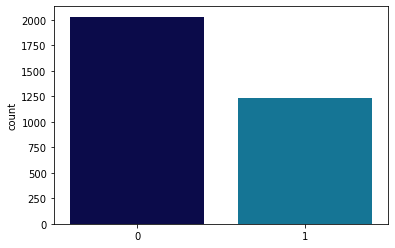

In [ ]:
## lets have a quick look at the predicted labels:
sns.countplot(x=pred, palette='ocean');

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# create dataframe for submission with ids and predicted labels:
test_ids = tweets_test['id']
sub = pd.DataFrame(np.c_[test_ids, pred], columns = ['id', 'target'])
sub.to_csv('/drive/My Drive/Bert_Sub2.csv', index=False)

After submitting the results to Kaggle, we got a public f-1 score of 0.83 which I think is quite good for a first try. But of course, we can make some adjustments in order to further increase this score. 

##  06 FUTURE WORK

- further fine tune the BERT Model (e.g. adjust the learning rate, etc.)
- try even bigger BERT models
- use other pretrained models from the transformers library such as Xlnet (which outperforms the BERT model in some cases)
- go back to the basic models and perform a more sophisticated tokenization process, especially the SVM showed some promising results even with the simplest tokenization technique. 